In [13]:
# 将原始函数拆成 LangGraph 工作流，并使用结构化输出
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import TypedDict, List, Optional
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


In [14]:
# 定义 Agent 类封装
class Agent:
    def __init__(self, instruction: str, role: str, model_info: str):
        self.role = role
        self.instruction = instruction
        self.model_info = model_info
        self.llm = ChatOpenAI(model=model_info)
        self.history = []  
    def chat(self, message: str) -> str:
        if not self.history:
            self.history.append({"role": "system", "content": f"You are a {self.role}.\nInstructions: {self.instruction}"})
        self.history.append({"role": "user", "content": message})
        response = self.llm.invoke(self.history)  # 使用 invoke 方法（新版）
        self.history.append({"role": "assistant", "content": response.content})
        return response.content
    


# 定义结构化输出模型
class ExpertAgent(BaseModel):
    role: str = Field(description="The expert's role or specialization.")
    description: str = Field(description="A brief description of their expertise.")
    hierarchy: Optional[str] = Field(description="Hierarchy relationship with others.")

class ExpertPlan(BaseModel):
    agents: List[ExpertAgent] = Field(description="List of recruited expert agents.")



# 定义共享状态结构
class WorkflowState(TypedDict):
    question: str
    model: str
    difficulty: Optional[str]
    agents_data: Optional[List[ExpertAgent]]
    agent_dict: Optional[dict]
    medical_agents: Optional[List]
    fewshot_examples: Optional[str]
    round_opinions: Optional[dict]
    final_answer: Optional[str]
    decision: Optional[str]

In [ ]:
def determine_difficulty(state: WorkflowState):
    question = state.get('question')
    difficulty = state.get('difficulty')

    if difficulty is not None:
        new_difficulty = difficulty
    else:
        difficulty_prompt = (
            f"Now, given the medical query as below, you need to decide the difficulty/complexity of it:\n"
            f"{question}.\n\n"
            "Please indicate the difficulty/complexity of the medical query among below options:\n"
            "1) basic: a single medical agent can output an answer.\n"
            "2) intermediate: number of medical experts with different expertise should dicuss and make final decision.\n"
            "3) advanced: multiple teams of clinicians from different departments need to collaborate with each other to make final decision."
        )

        medical_agent = Agent(
            instruction='You are a medical expert who conducts initial assessment and your job is to decide the difficulty/complexity of the medical query.',
            role='medical expert',
            model_info=state['model']
        )
        medical_agent.chat('You are a medical expert who conducts initial assessment and your job is to decide the difficulty/complexity of the medical query.')
        response = medical_agent.chat(difficulty_prompt)

        if 'basic' in response.lower() or '1)' in response.lower():
            new_difficulty = 'basic'
        elif 'intermediate' in response.lower() or '2)' in response.lower():
            new_difficulty = 'intermediate'
        elif 'advanced' in response.lower() or '3)' in response.lower():
            new_difficulty = 'advanced'
        else:
            new_difficulty = 'basic'  # 默认兜底

    # 只返回变动部分
    return {"difficulty": new_difficulty}


# 定义路由函数，根据难度选择不同的节点
def route_by_difficulty(state: WorkflowState):
    if state["difficulty"] == "basic":
        return "basic_node"
    elif state["difficulty"] == "intermediate":
        return "intermediate_node"
    elif state["difficulty"] == "advanced":
        return "advanced_node"


# Node: basic node 
def basic_node(state: WorkflowState):
    question = state["question"]
    model = state.get("model", "gpt-4o")


    # ！！！这里prompt特定写明了multiple choice questions（我觉得MDAgents是不是就针对数据集做了优化，比如medqa就用basic难度。）
    single_agent = Agent(
        instruction='You are a helpful assistant that answers multiple choice questions about medical knowledge.',
        role='medical expert',
        model_info=state['model']
    )
    single_agent.chat('You are a helpful assistant that answers multiple choice questions about medical knowledge.')

    final_decision = single_agent.chat(
        f'''The following are multiple choice questions (with answers) about medical knowledge. Let's think step by step.\n\n**Question:** {question}\nAnswer: ''',
        # img_path=None
    )

    return {"decision": final_decision}


# Node: advanced node (使用结构化输出)
def advanced_node(state: WorkflowState):
    # a tmp dummy node
    return {"decision": "This is an advanced node, please implement the logic for advanced complexity."}
    

# Nodes for intermediate questions

# Node: expert recruitment（使用结构化输出）
def recruit_agents(state: WorkflowState):
    llm = ChatOpenAI(model=state["model"])
    structured_llm = llm.with_structured_output(ExpertPlan)

    system_instruction = (
        "You are an experienced medical expert who recruits a group of experts with diverse identities and asks them to discuss and solve the given medical query."
    )

    expert_count = 5
    recruitment_task_prompt = (
        f"Question: {state['question']}\n\n"
        f"You can recruit {expert_count} experts in different medical expertise. "
        "Considering the medical question and the options for the answer, what kind of experts will you recruit to better make an accurate answer?\n"
        "Also, you need to specify the communication structure between experts (e.g., Pulmonologist == Neonatologist == Medical Geneticist == Pediatrician > Cardiologist), or indicate if they are independent.\n\n"
        "For example, if you want to recruit five experts, your answer can be like:\n"
        "1. Pediatrician - Specializes in the medical care of infants, children, and adolescents. - Hierarchy: Independent\n"
        "2. Cardiologist - Focuses on the diagnosis and treatment of heart and blood vessel-related conditions. - Hierarchy: Pediatrician > Cardiologist\n"
        "3. Pulmonologist - Specializes in the diagnosis and treatment of respiratory system disorders. - Hierarchy: Independent\n"
        "4. Neonatologist - Focuses on the care of newborn infants, especially those who are born prematurely or have medical issues at birth. - Hierarchy: Independent\n"
        "5. Medical Geneticist - Specializes in the study of genes and heredity. - Hierarchy: Independent\n\n"
        "Please answer in above format, and do not include your reason."
    )

    chat_messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": recruitment_task_prompt},
    ]

    plan = structured_llm.invoke(chat_messages)
    return {"agents_data": plan.agents}

    

# Node: initialize agents
def init_agents(state: WorkflowState):
    agents = []
    agent_dict = {}
    for agent in state["agents_data"]:
        role = agent.role.lower()
        desc = agent.description.lower()
        agent_obj = Agent(f"You are a {role} who {desc}", role, model_info=state['model'])
        agent_dict[role] = agent_obj
        agents.append(agent_obj)
    return {"agent_dict": agent_dict, "medical_agents": agents}


# Node: collect opinions with full participatory debate

def collect_opinions(state: WorkflowState):
    question = state['question']
    medical_agents = state['medical_agents']
    agent_dict = state['agent_dict']
    num_rounds = 5
    num_turns = 5

    round_opinions = {n: {} for n in range(1, num_rounds+1)}
    round_answers = {n: None for n in range(1, num_rounds+1)}

    # Round 1: Initial Opinions
    for role, agent in agent_dict.items():
        opinion = agent.chat(f'''Given the examplers, please return your answer to the medical query among the option provided.\n\nQuestion: {question}\n\nYour answer should be like below format.\n\nAnswer: ''')

        round_opinions[1][role] = opinion

    # Debate rounds
    for n in range(1, num_rounds+1):
        round_name = f"Round {n}"
        assessment = "\n".join(f"({k}): {v}" for k, v in round_opinions[n].items())

        # Initialize interaction log
        interaction_log = {f"Turn {t}": {f"Agent {i+1}": {f"Agent {j+1}": None for j in range(len(medical_agents))} for i in range(len(medical_agents))} for t in range(1, num_turns+1)}

        for turn_num in range(1, num_turns+1):
            turn_name = f"Turn {turn_num}"
            num_yes = 0
            for i, source_agent in enumerate(medical_agents):
                if turn_num >  1:
                    # use previous turn's comments
                    all_comments = "\n".join(
                        f"Agent {k} -> Agent {i+1}: {v.get(f'Agent {i+1}', '')}"
                        for k, v in interaction_log[f"Turn {turn_num-1}"].items()
                    )

                opinions = assessment if (n == 1 and turn_num == 1) else all_comments


                participate = source_agent.chat(
                    f"[{round_name} |{turn_name}]\n"
                    f"Given the opinions from other medical experts in your team, please indicate whether you want to talk to any expert (yes/no).\n\n"
                    f"Opinions:\n{opinions}"
                )


                if 'yes' in participate.lower():
                    agent_list_str = "\n".join(f"Agent {j+1}: {agent.role}" for j, agent in enumerate(medical_agents))

                    chosen = source_agent.chat(f"Enter the number of the expert you want to talk to:\n{agent_list_str}\nFor example, if you want to talk with Agent 1. Pediatrician, return just 1. If you want to talk with more than one expert, please return 1,2 and don't return the reasons.")

                    chosen_indices = [int(idx.strip()) for idx in chosen.replace('.', ',').split(',') if idx.strip().isdigit()]
  

                    for ce in chosen_indices:
                        target_agent = medical_agents[ce-1]
                        message = source_agent.chat(f"Please remind your medical expertise and then leave your opinion to an expert you chose (Agent {ce}. {target_agent.role}). You should deliver your opinion once you are confident enough and in a way to convince other expert with a short reason.")
                        interaction_log[f"Turn {turn_num}"][f"Agent {i+1}"][f"Agent {ce}"] = message
                    num_yes += 1
            if num_yes == 0:
                break
        if num_yes == 0:
            break
        # !!!可能有bug，为什么2turn 就结束了？？？？？ 原来代码会五轮结束


    return {"round_opinions": round_opinions}

# Node: summarize each agent's final decision
def finalize_per_agent(state: WorkflowState):
    final_answers = {}
    for agent in state['medical_agents']:
        response = agent.chat(f"Now that you've interacted with other medical experts, remind your expertise and the comments from other experts and make your final answer to the given question:\n{state['question']}\nAnswer: ")
        final_answers[agent.role] = response
    return {"final_answer": final_answers}

# Node: moderator final decision
def finalize_decision(state: WorkflowState):
    summary = "\n".join(f"({k}): {v}" for k, v in state['final_answer'].items())

    mod = Agent("You are a final medical decision maker who reviews all opinions from different medical experts and make final decision.", "moderator", model_info=state['model'])
    mod.chat('You are a final medical decision maker who reviews all opinions from different medical experts and make final decision.')
    
    # Create a summary of the agents' opinions
    # 这里“format:\nAnswer: C) 2th pharyngeal arch”好奇怪，改了
    # decision = mod.chat(f"Given each agent's final answer, please review each agent's opinion and make the final answer to the question by taking majority vote. Your answer should be like below format:\nAnswer: C) 2th pharyngeal arch\n{summary}\n\nQuestion: {state['question']}")
    decision = mod.chat(f"Given each agent's final answer, please review each agent's opinion and make the final answer to the question by taking majority vote. Your answer should be like below format:\nAnswer: \n{summary}\n\nQuestion: {state['question']}")
    return {"decision": decision}


In [ ]:
# 构建 LangGraph
builder = StateGraph(WorkflowState)
builder.add_node("determine_difficulty", RunnableLambda(determine_difficulty))
#-----
builder.add_node("basic_node", RunnableLambda(basic_node))
# builder.add_node("intermediate_node", RunnableLambda(intermediate_node))
builder.add_node("advanced_node", RunnableLambda(advanced_node))
#------


builder.add_node("recruit", RunnableLambda(recruit_agents))
builder.add_node("init_agents", RunnableLambda(init_agents))
builder.add_node("collect_opinions", RunnableLambda(collect_opinions))
builder.add_node("finalize_per_agent", RunnableLambda(finalize_per_agent))
builder.add_node("finalize", RunnableLambda(finalize_decision))

builder.set_entry_point("determine_difficulty")
builder.add_conditional_edges(
    "determine_difficulty",
    route_by_difficulty,
    {
        "basic_node": "basic_node",
        "intermediate_node": "recruit",
        "advanced_node": "advanced_node"
    }
)
# builder.add_edge("determine_difficulty", "recruit")
builder.add_edge("recruit", "init_agents")
builder.add_edge("init_agents", "collect_opinions")
builder.add_edge("collect_opinions", "finalize_per_agent")
builder.add_edge("finalize_per_agent", "finalize")
builder.set_finish_point("finalize")

medical_graph = builder.compile()

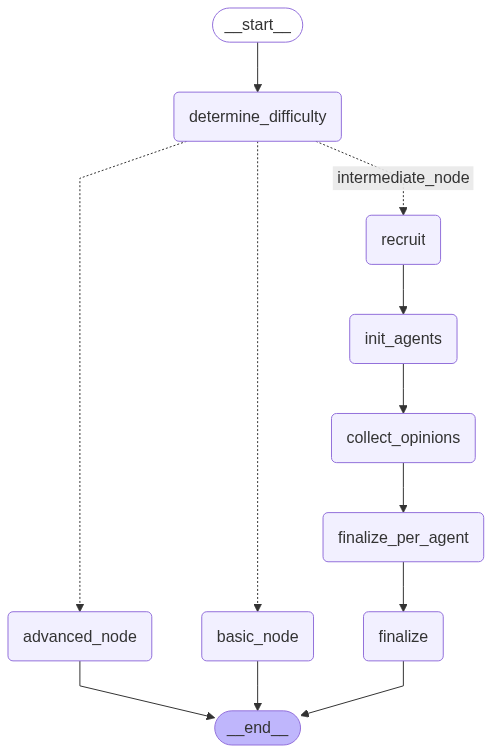

In [17]:
# Show the workflow
display(Image(medical_graph.get_graph().draw_mermaid_png()))

In [18]:

# 示例运行
input_state = {
    "question": " My daughter was diagnosed with cervical cancer, and the doctor mentioned potential treatment options.  However, she's decided against pursuing any of them, believing that since it's already spread (it's stage II), any intervention at this point would just prolong her suffering and not ultimately change the outcome.  She wants to focus on comfort care and making the most of her time.  Are there any hospice services that specialize in supporting young women with advanced cervical cancer?",
    "model": "gpt-4o",
    "difficulty": "intermediate",  # 这里可以设置为None触发难度判断
}
output = medical_graph.invoke(input_state)
print(output['decision'])

Answer: 

All experts consulted agree that hospice services can provide the support your daughter is seeking. Here is the consensus:

- **Oncologist:** Yes, hospice services are available to support young women with advanced cervical cancer, emphasizing comfort and quality of life. They offer individualized support, including pain management, emotional support, and complementary therapies. It’s recommended to reach out to local hospice providers and national organizations like the NHPCO for guidance.

- **Palliative Care Specialist:** Hospice and palliative care can be tailored to support young women with advanced cervical cancer, focusing on comfort and quality of life. They provide comprehensive support, including pain management and emotional support, and collaboration with healthcare teams enhances care.

- **Hospice Care Coordinator:** Yes, hospice services can specialize in supporting young women with advanced cervical cancer, focusing on comfort and personalized care. Engaging l